In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
import sys

WORKSPACE_PATH = Path.cwd().parent.parent
SRC_PATH = str(WORKSPACE_PATH / "src")

if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)
    print(f"echo $PATH={sys.path}")


%matplotlib inline

np.random.seed(1337)
random.seed(1337)

%load_ext autoreload
%autoreload 2

%load_ext autotime

echo $PATH=['/Users/jeanmetz/workspace/playground-llm-pytorch/src', '/Users/jeanmetz/.pyenv/versions/3.12.2/lib/python312.zip', '/Users/jeanmetz/.pyenv/versions/3.12.2/lib/python3.12', '/Users/jeanmetz/.pyenv/versions/3.12.2/lib/python3.12/lib-dynload', '', '/Users/jeanmetz/workspace/playground-llm-pytorch/.venv/lib/python3.12/site-packages']
time: 198 µs (started: 2024-11-17 15:22:02 +01:00)


In [2]:
from sklearn.datasets import make_moons
from micrograd.engine import Operand
from micrograd.nn import MLP
from typing import Iterable

time: 441 ms (started: 2024-11-17 15:22:02 +01:00)


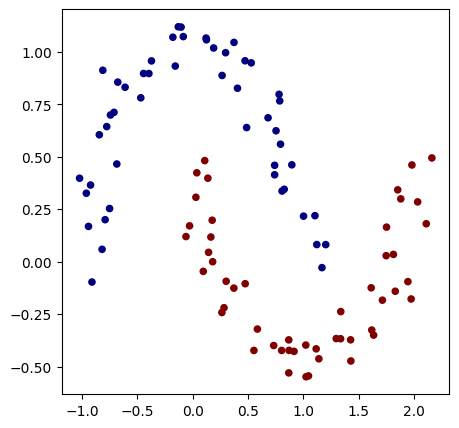

time: 120 ms (started: 2024-11-17 15:22:03 +01:00)


In [3]:
# make up a dataset
X, y = make_moons(n_samples=100, noise=0.1)
y = y * 2 - 1  # make y be -1 or 1

# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

In [4]:
def visualize_decision_boundary(model, data_points, true_labels, h=0.25, cmap=plt.cm.cividis):
    """
    Visualizes the decision boundary of the given model.
    """
    # Define the grid
    x_min, x_max = data_points[:, 0].min() - 1, data_points[:, 0].max() + 1
    y_min, y_max = data_points[:, 1].min() - 1, data_points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    data_mesh = np.c_[xx.ravel(), yy.ravel()]

    # Compute model predictions for the grid points
    inputs = [list(map(Operand, row)) for row in data_mesh]
    scores = list(map(model, inputs))  # Assumes model outputs scores for each class

    # Multi-class: Assign the class with the highest score to each point
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.6)  # Decision regions
    plt.scatter(data_points[:, 0], data_points[:, 1], c=true_labels, s=40, cmap=cmap, edgecolor="k")  # Data points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary")
    plt.show()

time: 1.02 ms (started: 2024-11-17 15:22:03 +01:00)


In [5]:
def max_margin_loss(model, true_labels: Iterable[Operand], scores: Iterable[Operand], alpha: float = 1e-4) -> float:
    """
    Computes the SVM "max-margin" loss with L2 regularization.

    Args:
        model: The model whose parameters are used for regularization.
        true_labels (Iterable[Operand]): The true labels (target values).
        scores (Iterable[Operand]): The model's predicted scores for the inputs.
        alpha (float): The regularization coefficient. Default is 1e-4.

    Returns:
        Operand: The total loss, combining data loss and L2 regularization loss.
    """
    # SVM "max-margin" data loss
    losses = [(1 + -y_i * score_i).relu() for y_i, score_i in zip(true_labels, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization loss
    reg_loss = alpha * sum(p * p for p in model.parameters())

    return data_loss + reg_loss

time: 1.06 ms (started: 2024-11-17 15:22:03 +01:00)


In [6]:
def train_loop(model, data_points, true_labels, epochs: int = 100, verbose: bool = False) -> None:
    for epoch in range(epochs):
        # forward the inputs into the model to get scores
        inputs = [list(map(Operand, sample)) for sample in data_points]
        scores = list(map(model, inputs))

        total_loss = max_margin_loss(model, true_labels, scores)
        accuracy = [(y_i > 0) == (score_i.data > 0) for y_i, score_i in zip(true_labels, scores)]
        accuracy = sum(accuracy) / len(accuracy)

        # backward
        model.zero_grad()
        total_loss.backward()

        # update (sgd)
        # use a simple schedule form of learning rate decay,
        # which linearly decreases over the course of training
        learning_rate = 1.0 - 0.9 * epoch / 100
        for p in model.parameters():
            p.data -= learning_rate * p.grad

        if verbose and epoch % 10 == 0:
            print(f"Epoch [{epoch}/{epochs}], Loss: {total_loss.data:.4f}, Acc: {accuracy * 100:.4f}%")

time: 1.33 ms (started: 2024-11-17 15:22:03 +01:00)


In [7]:
model = MLP(2, [16, 16, 1])  # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

train_loop(model, X, y, epochs=100, verbose=True)

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [linearNeuron(16)]]
number of parameters 337
Epoch [0/100], Loss: 0.9946, Acc: 50.0000%
Epoch [10/100], Loss: 0.3189, Acc: 86.0000%
Epoch [20/100], Loss: 0.2484, Acc: 91.0000%
Epoch [30/100], Loss: 0.2288, Acc: 89.0000%
Epoch [40/100], Loss: 0.1945, Acc: 91.0000%
Epoch [50/100], Loss: 0.1700, Acc: 92.0000%
Epoch [60/100], Loss: 0.1418, Acc: 94.0000%
Epoch [70/100], Loss: 0.1201, Acc: 95.0000%
Epoch [80/100], Loss: 0.0845, Acc: 97.0000%
Epoch [90/100], Loss: 0.0

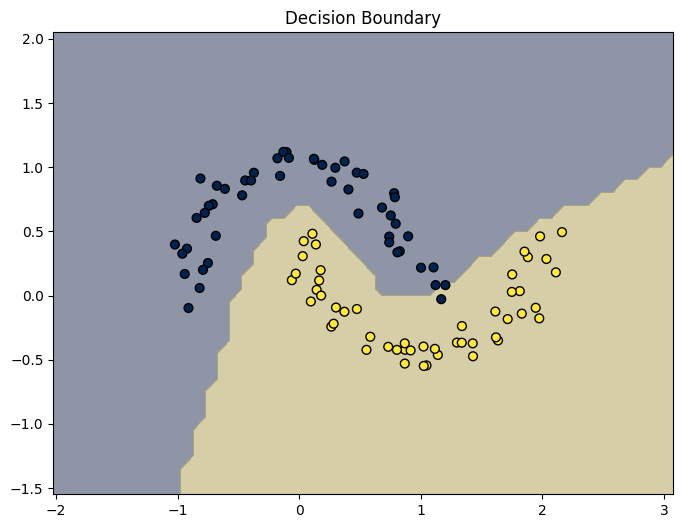

time: 9.23 s (started: 2024-11-17 15:23:03 +01:00)


In [8]:
visualize_decision_boundary(model, X, y, h=0.1)